# Complete Notebook

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from glob import glob

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects

import matplotlib.pyplot as plt
%matplotlib inline 

2021-09-17 18:54:02.077933: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Initializing Parameters

In [3]:
IMAGE_SIZE = [300,300, 3]

train_path = '/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Train'
test_path = '/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Test'
val_path = '/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Val'

## Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)



training_set = train_datagen.flow_from_directory('/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Train',
                                                 target_size = (300,300),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Test',
                                            target_size = (300,300),
                                            batch_size = 32,
                                            class_mode = 'categorical')
val_set = test_datagen.flow_from_directory('/kaggle/input/covid19-chest-xray-processed-dataset/Dataset/Val',
                                            target_size = (300,300),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3641 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


## Modified EfficientNetB2

In [5]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-iplwbidf
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-iplwbidf
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
     |████████████████████████████████| 50 kB 674 kB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=d1c08754bad36f29818b22f4d0bf55bce1c43af2022538f38cdddefb3063829a
  Stored in directory: /tmp/pip-ephem-wheel-cache-x1ndimk8/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [6]:
import efficientnet.tfkeras as enet

In [7]:
model = enet.EfficientNetB3(include_top=False, input_shape=(300,300,3), pooling='avg', weights='imagenet')

2021-09-17 18:54:19.898301: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 18:54:19.901467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-17 18:54:19.940129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 18:54:19.940761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-17 18:54:19.940804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-17 18:54:19.972577: I tensorflow/stream_executor/platform/def

44113920/44107200 [==============================] - 1s 0us/step


In [8]:
for layer in model.layers:
    layer.trainable = False

## Building Model

In [9]:
class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))


get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [10]:
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

predictions = Dense(2, activation="softmax")(x)

final_model = Model(inputs = model.input, outputs = predictions)

In [11]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

In [12]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

## Training

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

In [14]:
history = final_model.fit_generator(
    training_set,
    validation_data=val_set,
    epochs=100,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set),
    callbacks=[reduce_lr],
)

2021-09-17 18:54:28.330055: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-17 18:54:28.333963: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000144999 Hz


Epoch 1/100


2021-09-17 18:54:36.454305: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-17 18:54:37.508257: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-17 18:54:39.240981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


114/114 [==============================] - 270s 2s/step - loss: 0.3879 - accuracy: 0.8325 - val_loss: 0.1629 - val_accuracy: 0.9758
Epoch 2/100
114/114 [==============================] - 183s 2s/step - loss: 0.1282 - accuracy: 0.9574 - val_loss: 0.1049 - val_accuracy: 0.9780
Epoch 3/100
114/114 [==============================] - 183s 2s/step - loss: 0.1045 - accuracy: 0.9708 - val_loss: 0.0808 - val_accuracy: 0.9802
Epoch 4/100
114/114 [==============================] - 182s 2s/step - loss: 0.1105 - accuracy: 0.9600 - val_loss: 0.0702 - val_accuracy: 0.9780
Epoch 5/100
114/114 [==============================] - 183s 2s/step - loss: 0.0961 - accuracy: 0.9670 - val_loss: 0.0623 - val_accuracy: 0.9780
Epoch 6/100
114/114 [==============================] - 183s 2s/step - loss: 0.0814 - accuracy: 0.9708 - val_loss: 0.0569 - val_accuracy: 0.9824
Epoch 7/100
114/114 [==============================] - 184s 2s/step - loss: 0.0870 - accuracy: 0.9684 - val_loss: 0.0500 - val_accuracy: 0.9824
Epoc

## Testing

In [15]:
print("Evaluating on test data ....")
results = final_model.evaluate(test_set, batch_size=32)
print("test loss, test acc:", results)

Evaluating on test data ....
15/15 [==============================] - 35s 2s/step - loss: 0.0176 - accuracy: 0.9912
test loss, test acc: [0.017633000388741493, 0.9912087917327881]


## Plotting 

In [16]:
history.history

{'loss': [0.26367321610450745,
  0.12596198916435242,
  0.10824993997812271,
  0.10248111933469772,
  0.09412816166877747,
  0.0883321687579155,
  0.08126890659332275,
  0.06532399356365204,
  0.06775467097759247,
  0.0712367370724678,
  0.06477861851453781,
  0.06741709262132645,
  0.0527857206761837,
  0.06377853453159332,
  0.055622413754463196,
  0.05472121760249138,
  0.05829307436943054,
  0.05608472228050232,
  0.054253995418548584,
  0.06001795828342438,
  0.0549609400331974,
  0.0592462532222271,
  0.05361972749233246,
  0.05097884312272072,
  0.04870190471410751,
  0.05383600294589996,
  0.05724630877375603,
  0.06002404913306236,
  0.052322324365377426,
  0.048993512988090515,
  0.04543876647949219,
  0.04867768660187721,
  0.0487186573445797,
  0.04803440347313881,
  0.04738706350326538,
  0.04430212453007698,
  0.04232742264866829,
  0.04918862506747246,
  0.04336763545870781,
  0.04263165965676308,
  0.04090308025479317,
  0.05031880363821983,
  0.04192272201180458,
  0.0

### Accuracy vs Epochs

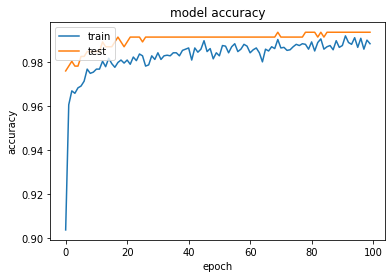

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Loss vs Epochs

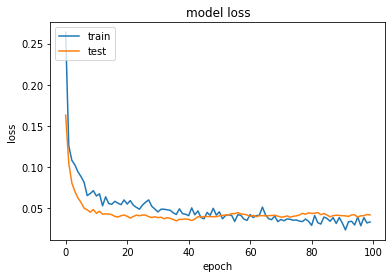

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()